# Propensity Model

## Preliminary Code (Importing Libraries, Loading the Dataset)

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE


In [2]:
march_2024 = pd.read_parquet('../Data/Product Flags/cust_info_prod_202403_processed.parquet')
cust_info = pd.read_parquet('../Data/Other Data/CUSTOMER INFO.parquet')
merged_df = pd.merge(march_2024, cust_info, on='CUST_NUM', how='inner')

## Data Cleaning

In [3]:
columns_to_keep = [
    'CUST_NUM', 'CORPORATE_LOANS', 'RETAIL_LOAN', 'TRADE_SERVICES', 'INVESTMENT_FUNDS',
    'SECURITIES', 'INSURANCE', 'CORPORATE_FINANCE', 'FOREX', 'REMITTANCE',
    'CORPORATE_CARDS', 'DEPOSITS', 'RETAIL_PRODUCTS', 'INVESTMENTS_AND_SECURITIES',
    'AGE', 'GENDER', 'MARITAL_STATUS', 'EDUCATION', 'INCOME_SOURCE',
    'BUSINESS_OWNER', 'PROVINCE', 'REGION', 'DIGITAL_FLAG', 'TENURE', 'SUBSEGMENT'
]

merged_df = merged_df[columns_to_keep]

## Exploratory Data Analysis

In [9]:
def check_class_imbalance(df, target_variable):
    class_counts = df[target_variable].value_counts()
    print(f"Class distribution for {target_variable}:\n{class_counts}")

    # Visualize the class distribution
    plt.bar(class_counts.index, class_counts.values, color=['blue', 'orange'])
    plt.title(f"Class Distribution for {target_variable}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks([0, 1], ['Not Purchased', 'Purchased'])
    plt.show()
    
def analyze_categorical_features(df, categorical_columns):
    for column in categorical_columns:
        print(f"\nValue counts for {column}:\n{df[column].value_counts()}")
        df[column].value_counts().plot(kind='bar', title=f"Distribution of {column}")
        plt.show()

def analyze_numerical_features(df, numerical_columns):
    print("Summary statistics for numerical features:")
    print(df[numerical_columns].describe())

    # Visualize distributions
    for column in numerical_columns:
        plt.hist(df[column].dropna(), bins=20, edgecolor='black')
        plt.title(f"Distribution of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()
def check_missing_values(df):
    missing_values = df.isnull().sum()
    missing_cols = missing_values[missing_values > 0]
    if not missing_cols.empty:
        print("Columns with missing values:\n", missing_cols)
    else:
        print("No missing values found.")


Class distribution for CORPORATE_LOANS:
0    297826
1       342
Name: CORPORATE_LOANS, dtype: int64


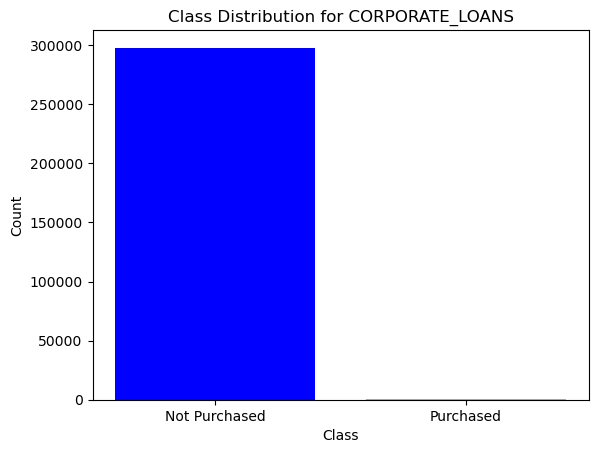

Class distribution for RETAIL_LOAN:
0    298035
1       133
Name: RETAIL_LOAN, dtype: int64


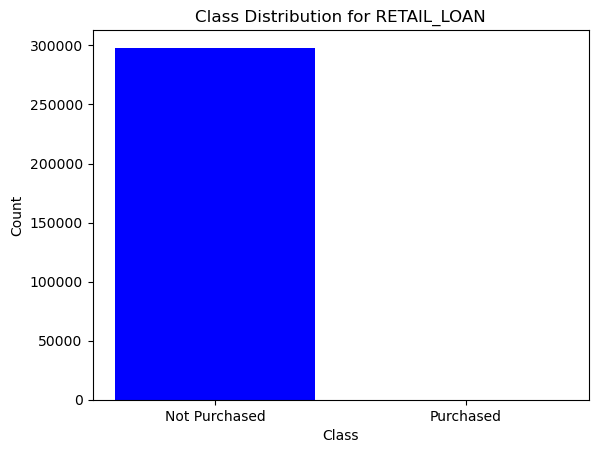

Class distribution for TRADE_SERVICES:
0    298158
1        10
Name: TRADE_SERVICES, dtype: int64


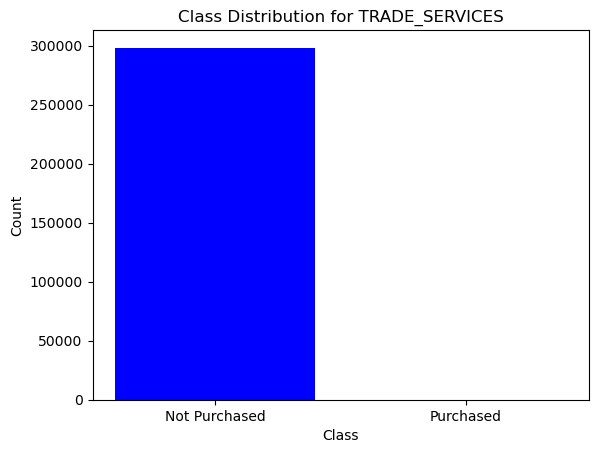

Class distribution for INVESTMENT_FUNDS:
0    298168
Name: INVESTMENT_FUNDS, dtype: int64


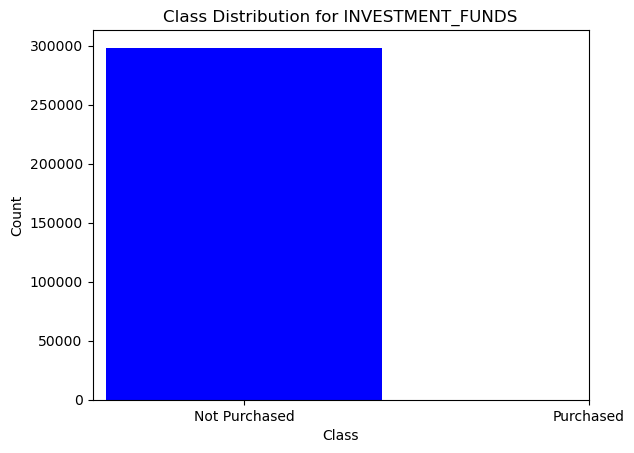

Class distribution for SECURITIES:
0    298168
Name: SECURITIES, dtype: int64


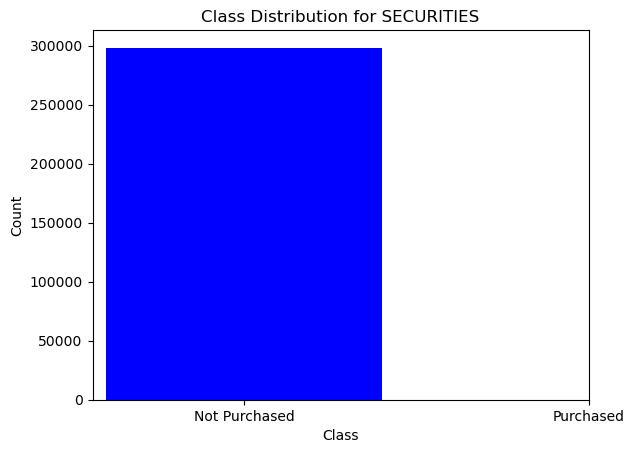

Class distribution for INSURANCE:
0    275787
1     22381
Name: INSURANCE, dtype: int64


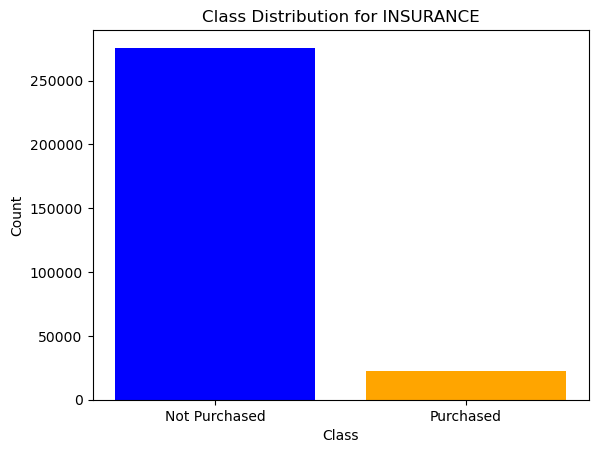

Class distribution for CORPORATE_FINANCE:
0    298168
Name: CORPORATE_FINANCE, dtype: int64


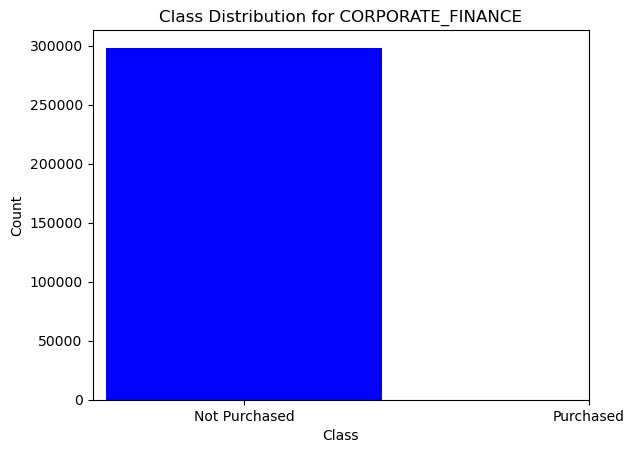

Class distribution for FOREX:
0    295978
1      2190
Name: FOREX, dtype: int64


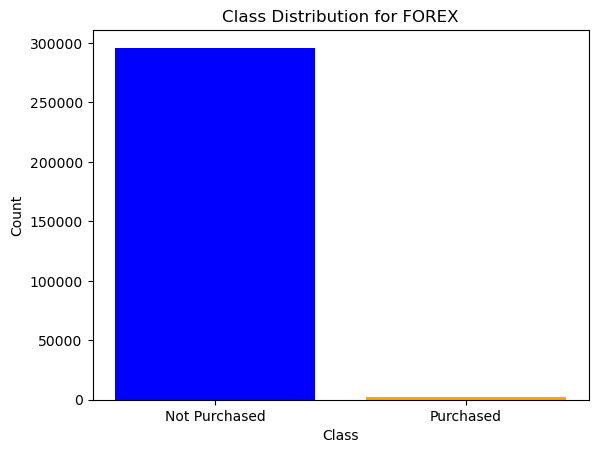

Class distribution for REMITTANCE:
0    298168
Name: REMITTANCE, dtype: int64


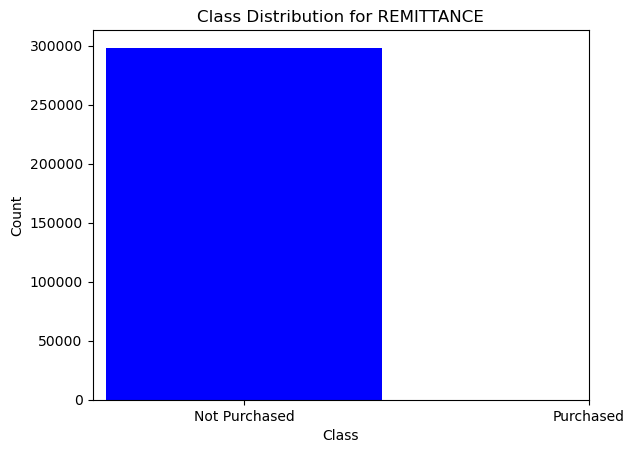

Class distribution for CORPORATE_CARDS:
0    298160
1         8
Name: CORPORATE_CARDS, dtype: int64


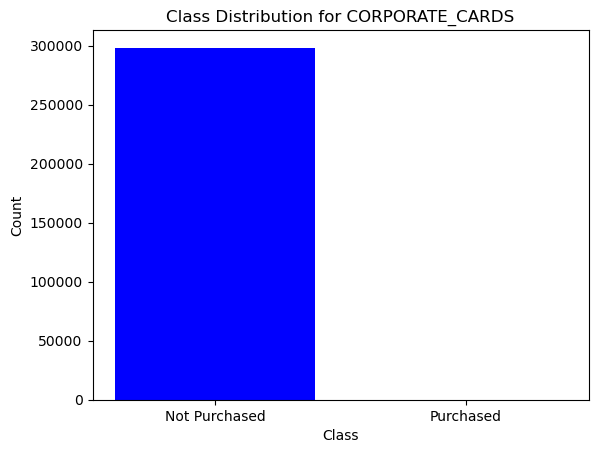

Class distribution for DEPOSITS:
1    297639
0       529
Name: DEPOSITS, dtype: int64


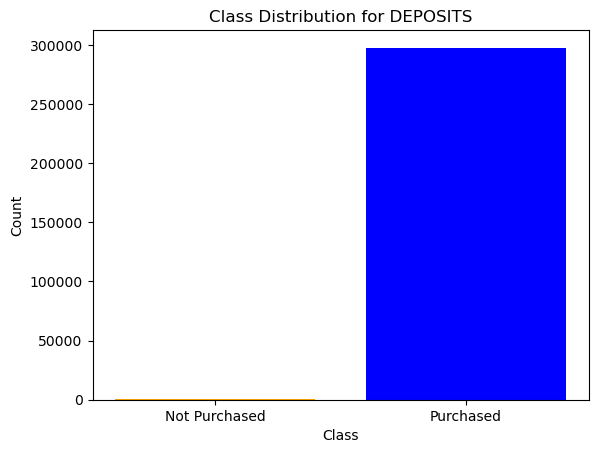

Class distribution for RETAIL_PRODUCTS:
0    247632
1     50536
Name: RETAIL_PRODUCTS, dtype: int64


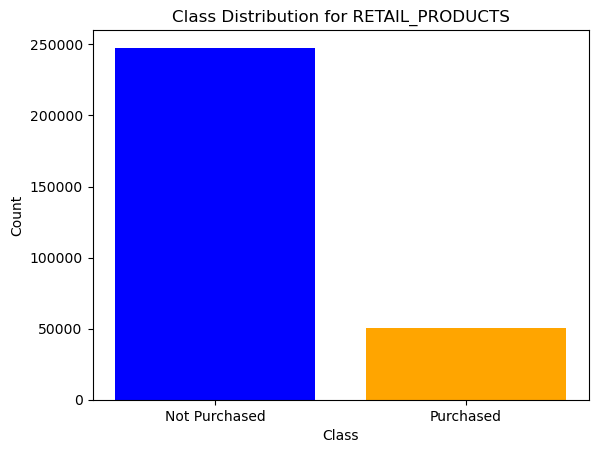

Class distribution for INVESTMENTS_AND_SECURITIES:
0    291118
1      7050
Name: INVESTMENTS_AND_SECURITIES, dtype: int64


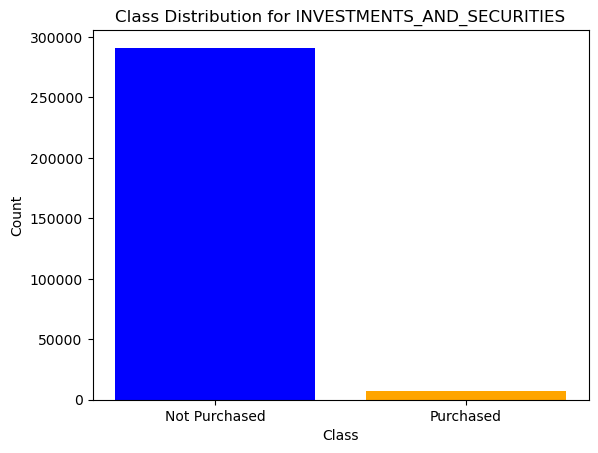

In [5]:
product_categories = ['CORPORATE_LOANS', 'RETAIL_LOAN', 'TRADE_SERVICES', 'INVESTMENT_FUNDS', 
                      'SECURITIES', 'INSURANCE', 'CORPORATE_FINANCE', 'FOREX', 
                      'REMITTANCE', 'CORPORATE_CARDS', 'DEPOSITS', 
                      'RETAIL_PRODUCTS', 'INVESTMENTS_AND_SECURITIES']

for target in product_categories:
    check_class_imbalance(merged_df, target)


Value counts for GENDER:
FEMALE    172878
MALE       75058
MLE        44255
OTHERS      5977
Name: GENDER, dtype: int64


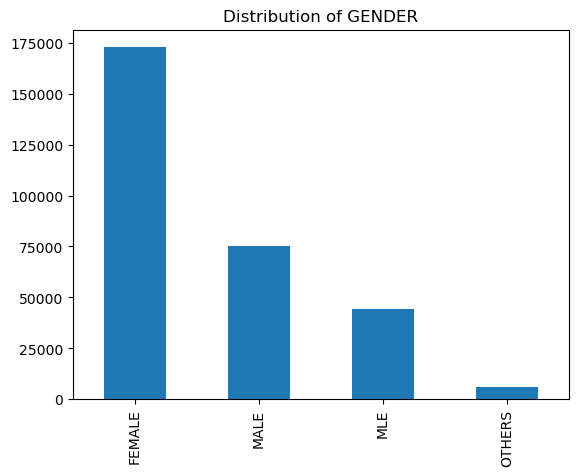


Value counts for MARITAL_STATUS:
SINGLE       167292
MARRIED      110413
WIDOWED        9230
DIVORCED       5415
OTHERS         2965
SEPARATED      2853
Name: MARITAL_STATUS, dtype: int64


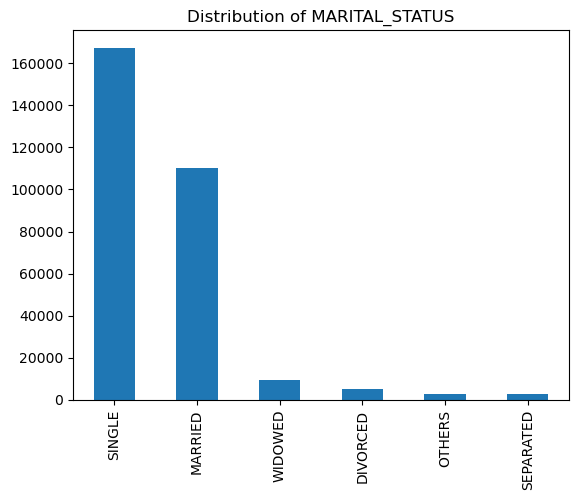


Value counts for EDUCATION:
MID        168419
LOW         63157
NO_DATA     58265
HIGH         8327
Name: EDUCATION, dtype: int64


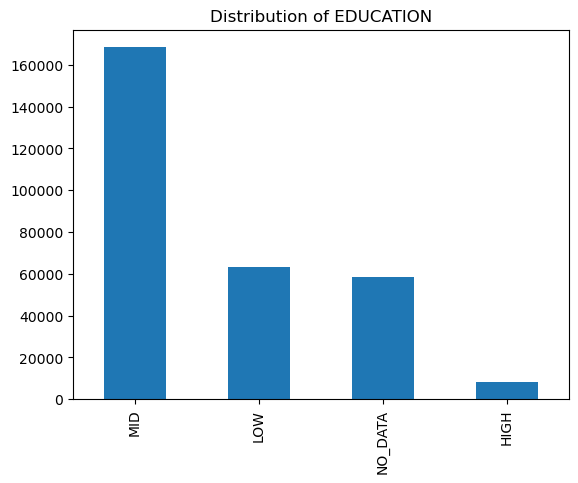


Value counts for INCOME_SOURCE:
SALARY                                     201648
ALLOWANCE                                   28878
PENSION                                     22407
BUSINESS                                    19202
REMITTANCE                                  14086
OTHER_SOURCES_NOT_SPECIFIED                  4036
NO_DATA                                      3574
COMMISSION                                   2498
INTEREST_SAVINGS_PLACEMENTS_INVESTMENTS      1307
ECONOMICALLY_INACTIVE                         487
DONATION                                       45
Name: INCOME_SOURCE, dtype: int64


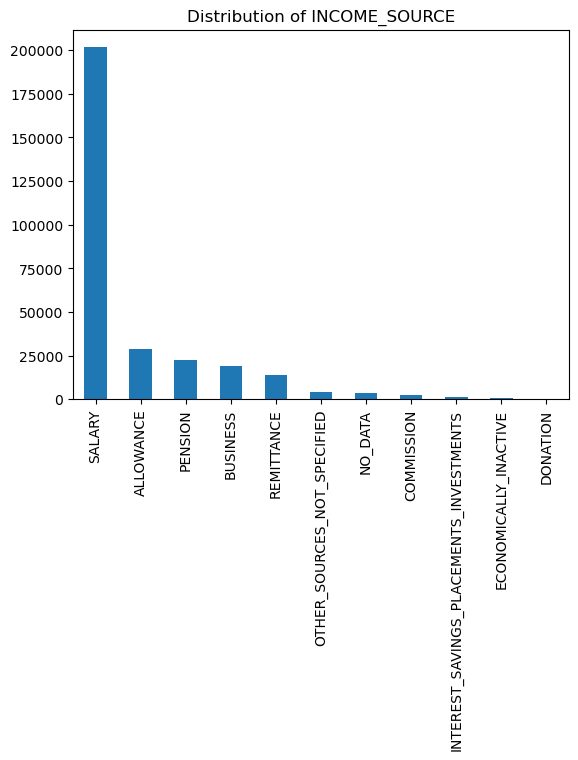


Value counts for BUSINESS_OWNER:
N    279758
Y     18410
Name: BUSINESS_OWNER, dtype: int64


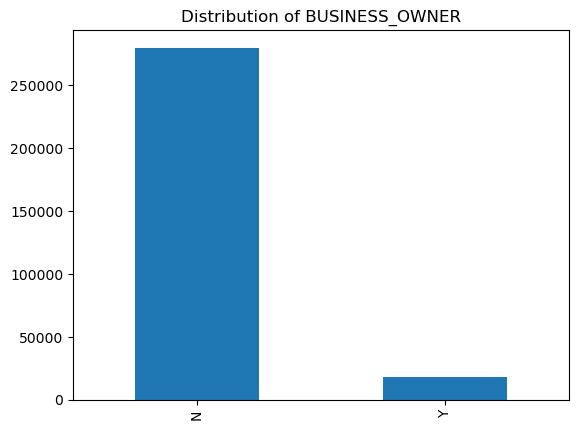


Value counts for PROVINCE:
NATIONAL CAPITAL REGION           128756
LAGUNA                             16196
CEBU                               16180
CAVITE                             15985
BATANGAS                            9368
BULACAN                             9130
PAMPANGA                            9108
RIZAL                               8541
DAVAO DEL SUR                       7779
ILOILO                              7543
NEGROS OCCIDENTAL                   6037
MISAMIS ORIENTAL                    4569
PANGASINAN                          4341
BENGUET                             4281
ZAMBALES                            2690
ZAMBOANGA DEL SUR                   2664
SOUTH COTABATO                      2463
NUEVA ECIJA                         2449
NEGROS ORIENTAL                     2328
LEYTE                               2268
QUEZON                              2262
BOHOL                               2186
TARLAC                              1989
CAMARINES SUR                

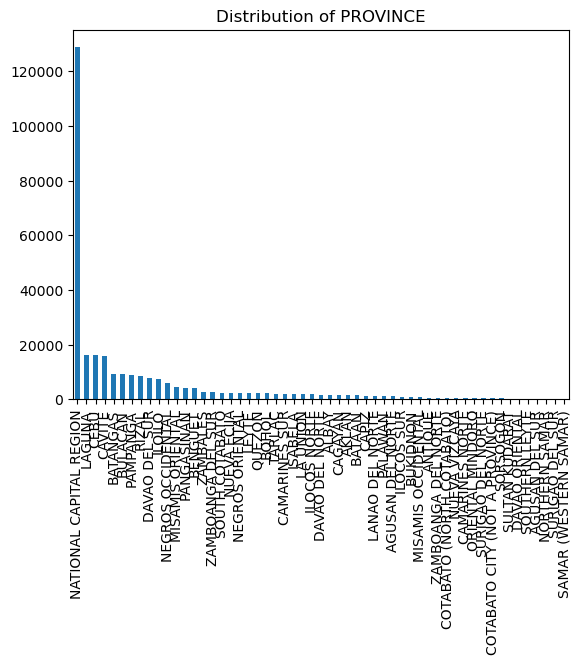


Value counts for REGION:
NATIONAL CAPITAL REGION                   128756
REGION IV-A (CALABARZON)                   52352
REGION III (CENTRAL LUZON)                 26852
REGION VII (CENTRAL VISAYAS)               20694
REGION VI (WESTERN VISAYAS)                17040
REGION XI (DAVAO REGION)                    9738
REGION I (ILOCOS REGION)                    9000
REGION X (NORTHERN MINDANAO)                7437
REGION V (BICOL REGION)                     4657
CORDILLERA ADMINISTRATIVE REGION (CAR)      4281
REGION II (CAGAYAN VALLEY)                  4039
REGION XII (SOCCSKSARGEN)                   3725
REGION IX (ZAMBOANGA PENINSULA)             3293
REGION VIII (EASTERN VISAYAS)               2680
REGION XIII (CARAGA)                        1950
MIMAROPA REGION                             1674
Name: REGION, dtype: int64


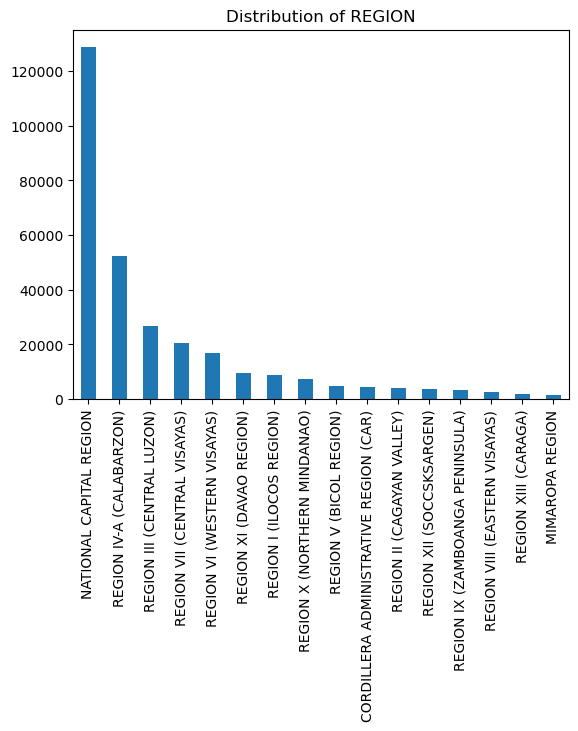


Value counts for SUBSEGMENT:
Lower Tier           183344
Middle Tier           65161
Upper-Middle Tier     49499
Top Tier                164
Name: SUBSEGMENT, dtype: int64


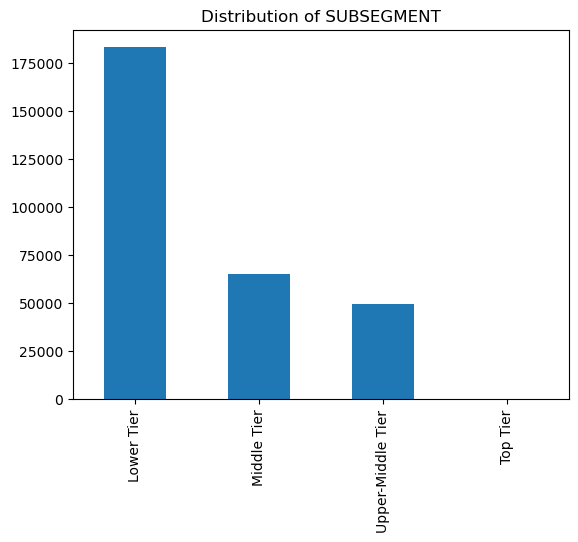

In [6]:
categorical_columns = ['GENDER', 'MARITAL_STATUS', 'EDUCATION', 'INCOME_SOURCE', 
                       'BUSINESS_OWNER', 'PROVINCE', 'REGION', 'SUBSEGMENT']
analyze_categorical_features(merged_df, categorical_columns)

Summary statistics for numerical features:
                 AGE         TENURE
count  297970.000000  298168.000000
mean       42.257660       8.921850
std        15.381008       6.323841
min         2.000000       0.926027
25%        30.000000       4.150685
50%        38.000000       7.515068
75%        51.000000      12.210959
max       134.000000      31.145205


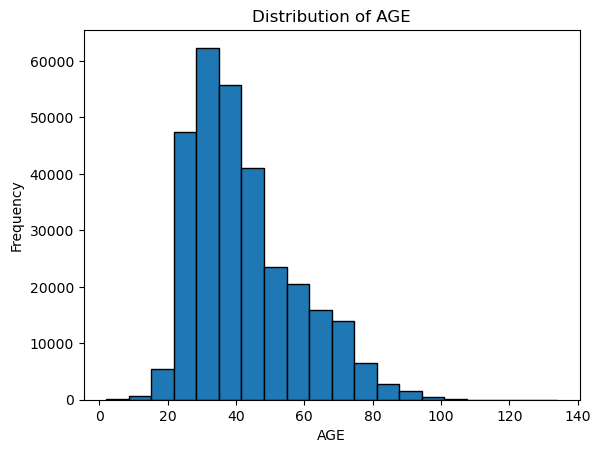

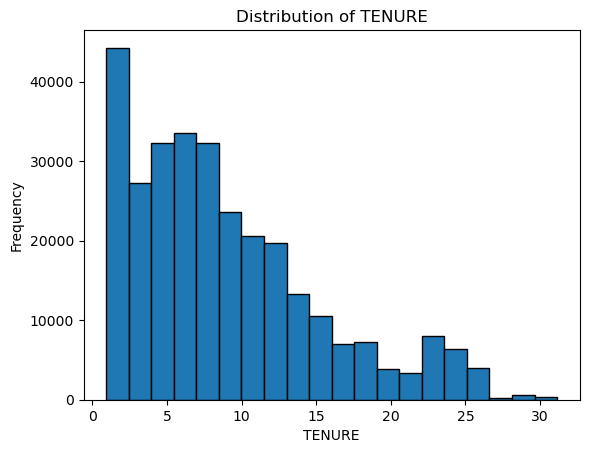

In [7]:
numerical_columns = ['AGE', 'TENURE']
analyze_numerical_features(merged_df, numerical_columns)

In [10]:
check_missing_values(merged_df)

Columns with missing values:
 AGE    198
dtype: int64


## Data Preprocessing

### Removing Null Values

In [14]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
merged_df['AGE'] = imputer.fit_transform(X[['AGE']])

### Defining the Feature Matrix and Target Variable

In [15]:
target_product = 'INSURANCE'
X = merged_df.drop(columns=['CUST_NUM', target_product])  
y = merged_df[target_product] 



Class distribution after SMOTE:
1    193050
0    193050
Name: INSURANCE, dtype: int64


/Users/benjaminang/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:06:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC-AUC Score: 0.731747676813166
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     82737
           1       0.18      0.41      0.25      6714

    accuracy                           0.82     89451
   macro avg       0.57      0.63      0.58     89451
weighted avg       0.89      0.82      0.85     89451



### One-Hot Encoding

In [ ]:
categorical_columns = ['GENDER', 'MARITAL_STATUS', 'EDUCATION', 'INCOME_SOURCE', 
                       'BUSINESS_OWNER', 'PROVINCE', 'REGION', 'SUBSEGMENT', 'DIGITAL_FLAG']
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

### Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Smote to Handle Class Imbalance

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Display the new class distribution after applying SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


## Model Training

In [ ]:
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_resampled, y_train_resampled)

## Model Validation

In [ ]:
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_report_output = classification_report(y_test, y_pred)

print(f"ROC-AUC Score: {roc_auc}")
print("Classification Report:")
print(classification_report_output)

## Hyperparameter Tuning

In [16]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'scale_pos_weight': [1, len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Set up the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)

# Fit the model with the best hyperparameters
grid_search.fit(X_train_resampled, y_train_resampled)

# Retrieve the best model and its parameters
best_model = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_report_output = classification_report(y_test, y_pred)

print(f"ROC-AUC Score: {roc_auc}")
print("Classification Report:")
print(classification_report_output)


Class distribution after SMOTE:
1    193050
0    193050
Name: INSURANCE, dtype: int64
Fitting 3 folds for each of 216 candidates, totalling 648 fits


/Users/benjaminang/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:10:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/benjaminang/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:10:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/benjaminang/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:10:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/benjaminang/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:10:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sms

Best Hyperparameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'scale_pos_weight': 1, 'subsample': 0.8}
ROC-AUC Score: 0.7254034446009496
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.91     82737
           1       0.19      0.36      0.25      6714

    accuracy                           0.83     89451
   macro avg       0.57      0.62      0.58     89451
weighted avg       0.89      0.83      0.86     89451

